In [2]:
#instalka pythona 3.10 pod collaba xd
!wget https://www.python.org/ftp/python/3.10.13/Python-3.10.13.tgz
!tar xvf Python-3.10.13.tgz
%cd Python-3.10.13
!./configure
!make
!sudo make install


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Compiling '/usr/local/lib/python3.10/test/_test_embed_set_config.py'...
Compiling '/usr/local/lib/python3.10/test/_test_multiprocessing.py'...
Compiling '/usr/local/lib/python3.10/test/_typed_dict_helper.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module2.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module3.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module4.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module5.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module6.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module7.py'...
Compiling '/usr/local/lib/python3.10/test/audiotests.py'...
Compiling '/usr/local/lib/python3.10/test/audit-tests.py'...
Compiling '/usr/local/lib/python3.10/test/autotest.py'...
Compiling '/usr/local/lib/python3.10/test/bad_getattr.py'...
Compiling '/usr/local/lib/python3.10/test/bad_getattr2.py'

In [3]:
!python --version


Python 3.10.13


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import zipfile
import os

In [8]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
with zipfile.ZipFile('UCI HAR Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2025-03-24 15:46:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip.1’

UCI HAR Dataset.zip     [                <=> ]  58.17M  18.5MB/s    in 3.3s    

2025-03-24 15:46:53 (17.7 MB/s) - ‘UCI HAR Dataset.zip.1’ saved [60999314]



In [9]:
train_data = pd.read_csv('./UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
train_labels = pd.read_csv('./UCI HAR Dataset/train/y_train.txt', delim_whitespace=True, header=None)

test_data = pd.read_csv('./UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
test_labels = pd.read_csv('./UCI HAR Dataset/test/y_test.txt', delim_whitespace=True, header=None)


<ipython-input-9-5cd4ad5c4b76>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv('./UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
<ipython-input-9-5cd4ad5c4b76>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_labels = pd.read_csv('./UCI HAR Dataset/train/y_train.txt', delim_whitespace=True, header=None)
<ipython-input-9-5cd4ad5c4b76>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv('./UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
<ipython-input-9-5cd4ad5c4b76>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'``

In [10]:
print("Rozmiar danych treningowych:", train_data.shape)
print("Rozmiar danych testowych:", test_data.shape)

Rozmiar danych treningowych: (7352, 561)
Rozmiar danych testowych: (2947, 561)


In [11]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_data, train_labels.values.ravel())

RandomForestClassifier(random_state=42)

In [12]:
y_pred = rf_model.predict(test_data)

print("\n🎯 Accuracy:", accuracy_score(test_labels, y_pred))
print("\n📊 Classification Report:\n", classification_report(test_labels, y_pred))
print("\n🟦 Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))


🎯 Accuracy: 0.9256871394638616

📊 Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.97      0.93       496
           2       0.88      0.89      0.89       471
           3       0.97      0.86      0.91       420
           4       0.91      0.90      0.90       491
           5       0.91      0.92      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.93      0.93      2947


🟦 Confusion Matrix:
 [[479  12   5   0   0   0]
 [ 44 421   6   0   0   0]
 [ 16  43 361   0   0   0]
 [  0   0   0 441  50   0]
 [  0   0   0  43 489   0]
 [  0   0   0   0   0 537]]


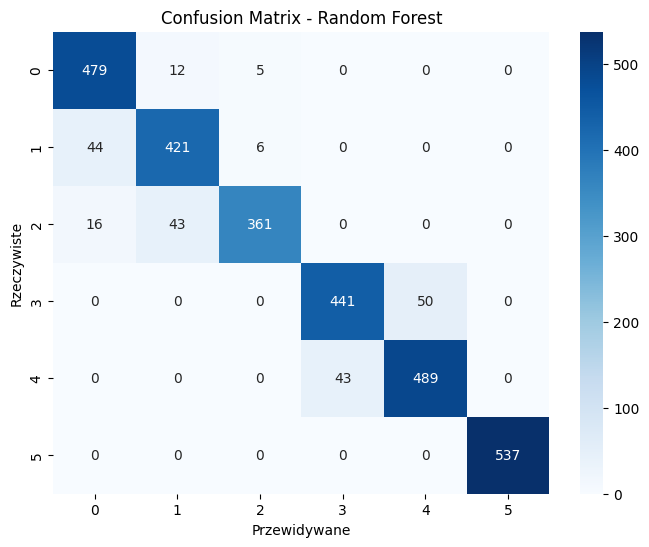

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_labels, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()